&emsp;&emsp;语言模型说的是给定一个文本序列$x_{1}, \cdots, x_{T}$, 语言模型的目标是估计联合概率$p(x_{1},\cdots, x_{T})$。相关的应用有：

1. 做个预训练模型，像`BERT`、`GPT-3`这样的。

2. 生成文本，比如说给定前面的几个词，不断的使用$x_{t} \sim p(x_{t} | x_{0}, \sim x_{t-1})$生成后续文本。

3. 判断多个序列中哪个更常见，比如语音模型输出多个可选项，因为一个意思可以用多种话来说，因此判断哪种方式出现的概率比较高也是有必要的。

## 使用计数来建模

&emsp;&emsp;假设序列长度为`2`，我们想要去预测$p(x_{1}, x_{2})$, 假设我们总共有$n$个词，$n(x_{1}), n(x_{1}, x_{2})$是单个词和连续词对出现的概率：

$$
p(x_{1}, x_{2}) = p(x_{1}) p(x_{1} | x_{2}) = \frac{n(x_{1})}{n} \frac{n(x_{1}, x_{2})}{n(x_{2})}
$$

### N元语法

&emsp;&emsp;当序列很长时，因为文本量不够大，很可能$n(x_{1}, \cdots, x_{T}) \leq 1$。一旦说会出现0个的现象的话，整个概率乘起来就会等于`0`了。可以采用马尔可夫假设来缓解这个问题：

1. **一元语法**: 

$$
p(x_{1}, x_{2}, x_{3}, x_{4}) = p(x_{1}) p(x_{2}) p(x_{3}) p(x_{4}) = \frac{n(x_{1})}{n} \frac{n(x_{2})}{n} \frac{n(x_{3})}{n} \frac{n(x_{4})}{n}
$$

2. **二元语法**: 

$$
p(x_{1}, x_{2}, x_{3}, x_{4}) = p(x_{1}) p(x_{2}｜x_{1}) p(x_{3}|x_{2}) p(x_{4} | x_{3}) = \frac{n(x_{1})}{n} \frac{n(x_{1}, x_{2})}{n(x_{1})} \frac{n(x_{2}, x_{3})}{n(x_{2})} \frac{n(x_{3}, x_{4})}{n(x_{4})}
$$

### 代码

In [1]:
import random
import torch
import sys
sys.path.append("..")
from d2l import torch as d2l

In [2]:
tokens = d2l.tokenize(d2l.read_time_machine())
print('tokens\n', tokens)

tokens
 [['the', 'time', 'machine', 'by', 'h', 'g', 'wells'], [], [], [], [], ['i'], [], [], ['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him'], ['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and'], ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the'], ['fire', 'burned', 'brightly', 'and', 'the', 'soft', 'radiance', 'of', 'the', 'incandescent'], ['lights', 'in', 'the', 'lilies', 'of', 'silver', 'caught', 'the', 'bubbles', 'that', 'flashed', 'and'], ['passed', 'in', 'our', 'glasses', 'our', 'chairs', 'being', 'his', 'patents', 'embraced', 'and'], ['caressed', 'us', 'rather', 'than', 'submitted', 'to', 'be', 'sat', 'upon', 'and', 'there', 'was', 'that'], ['luxurious', 'after', 'dinner', 'atmosphere', 'when', 'thought', 'roams', 'gracefully'], ['free', 'of', 'the', 'trammels', 'of', 'precision', 'and', 'he', 'put', 'it', 'to', 'us', 'in', 'this'

### 一元词频统计

In [3]:
corpus = [token for line in tokens for token in line]
print(corpus)

['the', 'time', 'machine', 'by', 'h', 'g', 'wells', 'i', 'the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him', 'was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and', 'twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the', 'fire', 'burned', 'brightly', 'and', 'the', 'soft', 'radiance', 'of', 'the', 'incandescent', 'lights', 'in', 'the', 'lilies', 'of', 'silver', 'caught', 'the', 'bubbles', 'that', 'flashed', 'and', 'passed', 'in', 'our', 'glasses', 'our', 'chairs', 'being', 'his', 'patents', 'embraced', 'and', 'caressed', 'us', 'rather', 'than', 'submitted', 'to', 'be', 'sat', 'upon', 'and', 'there', 'was', 'that', 'luxurious', 'after', 'dinner', 'atmosphere', 'when', 'thought', 'roams', 'gracefully', 'free', 'of', 'the', 'trammels', 'of', 'precision', 'and', 'he', 'put', 'it', 'to', 'us', 'in', 'this', 'way', 'marking', 'the', 'points', 'with', 'a', 'le

In [4]:
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

In [5]:
freqs = [freq for token, freq in vocab.token_freqs]
print(freqs)

[2261, 1267, 1245, 1155, 816, 695, 552, 541, 443, 440, 437, 354, 281, 270, 243, 221, 216, 204, 200, 158, 152, 137, 137, 134, 129, 127, 123, 122, 122, 122, 120, 118, 114, 114, 113, 113, 112, 106, 105, 103, 94, 93, 92, 92, 91, 89, 88, 87, 86, 85, 85, 85, 84, 84, 82, 79, 77, 75, 74, 74, 74, 73, 72, 71, 70, 70, 70, 69, 66, 62, 61, 60, 59, 59, 57, 57, 57, 55, 54, 54, 53, 52, 51, 50, 49, 49, 49, 49, 49, 49, 48, 48, 47, 47, 46, 46, 46, 46, 45, 45, 44, 43, 43, 43, 42, 42, 41, 40, 40, 40, 40, 39, 38, 38, 37, 37, 37, 37, 37, 36, 36, 36, 36, 36, 36, 35, 35, 35, 35, 35, 34, 34, 34, 34, 34, 34, 33, 33, 33, 32, 32, 32, 32, 32, 31, 31, 31, 30, 30, 30, 29, 29, 28, 28, 28, 28, 28, 28, 27, 27, 27, 27, 27, 26, 26, 26, 26, 26, 26, 26, 25, 25, 25, 25, 24, 24, 24, 24, 24, 23, 23, 23, 23, 23, 23, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17,

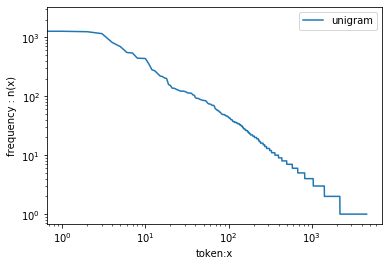

In [6]:
def PlotFrequence(freqs_list, legend_list):
    import matplotlib.pyplot as plt
    for i, freqs in enumerate(freqs_list):
        plt.plot(freqs, label=legend_list[i])
        plt.xlabel('token:x')
        plt.ylabel('frequency : n(x)')
        plt.xscale('log') # 以对数的形式展示出横纵坐标的值。
        plt.yscale('log')
        plt.legend()
    plt.show()
PlotFrequence([freqs], legend_list=['unigram'])

&emsp;&emsp;可以发现大部分的词频都是集中在很小一部分词汇上。

### 二元词频统计

In [7]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]
# print(bigram_vocab.token_freqs[:10])

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

### 三元词频统计

In [8]:
triple_tokens = [pair for pair in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
triple_vocab = d2l.Vocab(triple_tokens)
triple_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

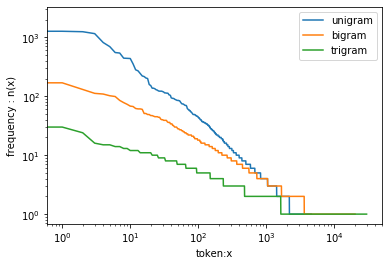

In [9]:
bigram_freqs = [bi_freq for token, bi_freq in bigram_vocab.token_freqs]
triple_freqs = [tri_freq for token, tri_freq in triple_vocab.token_freqs]
PlotFrequence([freqs, bigram_freqs, triple_freqs], legend_list=['unigram', 'bigram', 'trigram'])

&emsp;&emsp;可以看到大部分的词出现的概率其实是很低的。

## 创建数据集

### 生成随机序列样本

&emsp;&emsp;随机地生成一个小批量数据的特征和标签以供读取。在随机采样中，每个样本都是在原始的长序列上任意捕获的子序列。

In [10]:
def seq_data_iter_random(corpus, batch_size, num_steps):
    """
    corpus: 给定的一个很长的序列。
    batch_size: 
    num_steps: 时间长度就是t。
    """
    corpus = corpus[random.randint(0, num_steps - 1): ]  # 前面随机丢掉一点。
    num_subseqs = (len(corpus) - 1) // num_steps  # 可以生成的子序列的个数。
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps)) # 每个子序列开始的下标。
    
    random.shuffle(initial_indices)
    
    def data(pos):
        return corpus[pos: pos + num_steps]
    
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        initial_indices_per_batch = initial_indices[i : i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [12]:
# 验证
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X:', X, '\nY', Y)

X: tensor([[ 1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10]]) 
Y tensor([[ 2,  3,  4,  5,  6],
        [ 7,  8,  9, 10, 11]])
X: tensor([[26, 27, 28, 29, 30],
        [21, 22, 23, 24, 25]]) 
Y tensor([[27, 28, 29, 30, 31],
        [22, 23, 24, 25, 26]])
X: tensor([[11, 12, 13, 14, 15],
        [16, 17, 18, 19, 20]]) 
Y tensor([[12, 13, 14, 15, 16],
        [17, 18, 19, 20, 21]])


### 生成有序序列样本

In [13]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """使用顺序分区生成一个小批量子序列"""
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset : offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1 : offset + num_tokens + 1])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i : i + num_steps]
        Y = Ys[:, i : i + num_steps]
        yield X, Y

In [14]:
# 验证
my_seq = list(range(35))
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X:', X, '\nY', Y)

X: tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]]) 
Y tensor([[ 3,  4,  5,  6,  7],
        [19, 20, 21, 22, 23]])
X: tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]]) 
Y tensor([[ 8,  9, 10, 11, 12],
        [24, 25, 26, 27, 28]])
X: tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]]) 
Y tensor([[13, 14, 15, 16, 17],
        [29, 30, 31, 32, 33]])


### 包装采样函数

&emsp;&emsp;将两个采样函数包到一个类中：

In [26]:
class SeqDataLoader(object):
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_token):
        """
        use_random_iter: 是否使用一个随机的迭代器。
        max_token: 如果token比较大的话，取个比较小的token出来即可。
        """
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_token)
        self.batch_size, self.num_steps = batch_size, num_steps
    
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

&emsp;&emsp;最后，定义一个函数`load_data_time_machine`，它同时返回数据迭代器和词汇表。

In [27]:
def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词汇表。"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [28]:
load_data_time_machine(batch_size=2, num_steps=5, use_random_iter=False, max_tokens=10000)

(<__main__.SeqDataLoader at 0x7fa0e7048208>,
 <d2l.torch.Vocab at 0x7fa0e7022eb8>)